# Alloyed Data Science Challenge

**Goal:** Estimate the density of additively manufactured parts.

**Method:** Supervised because we have labels. Regression because the target is continuous.

**Base Model:** Linear regression. `sklearn.linear_model.Ridge`

**Other Models:** 
- Feedforward neural network. `sklearn.neural_network.MLPRegressor`
- Gradient boosting regressor. `sklearn.ensemble.GradientBoostingRegressor`

**Outline:**
- Read data
- EDA
- Data preprocessing
- Model selection
- Regularisation of the selected model
- Final predictions on unseen data

## Report

Density has huge importance in additive manufacturing as it determines material properties like stiffness or thermal behaviours ([Gor et al., 2022](https://doi.org/10.3390/app12147271)). In the paper, they achieved R2 scores higher than 0.9 with feedforward neural networks, k-neighbours, and support vector machines. However, considering the data available, I expect that my best-performing algorithm will be the gradient-boosted regressor.

I decided to use scikit-learn libraries instead of Pytorch. The main reasons were that the data is tabular, not dependent on time, and the dataset is small. 

The data was already clean; it didn't have any missing values that required imputing. MinMax scaling is most suitable as features are not distributed normally.

I removed features: 'Parameter,' 'X_coord,' and 'Y_coord.' Intuitively, we can see that they don't have an effect on density. All other features are used because there is no high correlation between them, indicating that there is no redundancy.

Even though all of the features in the provided data are numerical, some of them show categorical characteristics as they have 3-4 unique values. Therefore, using a tree-based algorithm can perform well. Also, they perform well with tabular data.

A simple linear regression model might not capture the complex relationships between features and the target variable.

I don't think a feedforward neural network will perform well here because we don't have enough data. Transfer learning could be a huge advantage, but I couldn't find any pre-trained model for density prediction of additively manufactured materials.

The best performing model was Gradient Boosted Trees. The resulting model is not very generalisable as we need more data for training. It still has some overfitting.

### Gradient Boosted Regressor

After the comparison plot, I decided to use `sklearn.ensemble.GradientBoostingRegressor` as my main model. I will provide some explanation about how it works.

Firstly, it is a variant of ensemble tree methods where multiple decision trees are combined. It is frequently used with tabular data as it performs really well compared to other tree-based methods. The main idea behind its better performance is the fact that it uses residuals to create new trees. This way, the model focuses on improving the regions where it performs poorly, and each additional tree reduces the error.

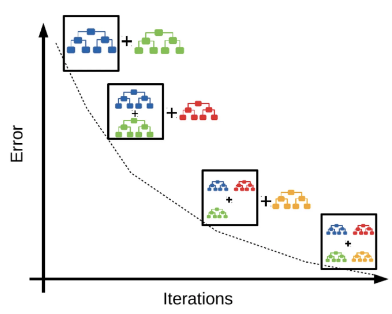

We will tune three model parameters:
- Learning rate
- Number of trees
- Maximum depth

Its advantages are:
- Handle small-sized data effectively
- Good with tabular data

### Sparse datasets

Sparse data is different from data that has missing values. Sparse data means it contains a high amount of zeros.

One-hot encoding can lead to sparse data as it makes all the other features zero except one.

Main problems:
- Overfitting: 
    - Generally, sparse datasets have a large number of features, and the ML model can have difficulties selecting which ones are important. If they try to fit each feature, then it overfits and performs badly on unseen data.
- Loss of information:
    - Some ML methods underestimate sparse data because they mostly consist of zeros and only fit dense data.
- High memory and time requirements: 
    - They generally have a very high number of features, leading to long training times.

How can we mitigate these problems:
- Converting it to a dense dataset:
    - We can select a new feature set that is not sparse with model reduction techniques such as Principle Component Analysis.
    - t-SNE is another dimensionality reduction technique that can be used.
- Dropping sparse features:
    - We can drop sparse features if they are not useful or if they have a high correlation with other features.
- Feature hashing:
    - Several features can be mapped into a vector, reducing sparsity.
- Using models that perform well on sparse data.
    - Multilayer perceptron (FNN) and support vector machines are good with sparse data. If the feature amount is not too high, tree-based models also can perform well.

## Imports

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Read Data

In [43]:
df = pd.read_csv('data/AssessmentData19Feb2024.csv')
df.head()

,Parameter,Laser Power,Hatch Distance,X_coord,Y_coord,Gas flow rate in m/s,Laser Speed,layer thickness,Total density
0,1,225,0.09,3,2,10.0,750,3,98.05
1,2,275,0.09,3,2,10.5,750,0,99.77
2,3,310,0.09,2,4,12.0,750,0,99.65
3,4,330,0.09,3,1,12.0,750,3,98.63
4,5,350,0.09,1,3,11.0,750,0,98.74


Check duplicates.

In [44]:
df.duplicated().sum()

0

Delete outliers.

In [45]:
# drop total density < 96
df = df[df['Total density'] >= 96]

## Split Data

In [46]:
y = df['Total density']
X = df.drop('Total density', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

## EDA: Exploratory Data Analysis
---

In [47]:
df.head()

,Parameter,Laser Power,Hatch Distance,X_coord,Y_coord,Gas flow rate in m/s,Laser Speed,layer thickness,Total density
0,1,225,0.09,3,2,10.0,750,3,98.05
1,2,275,0.09,3,2,10.5,750,0,99.77
2,3,310,0.09,2,4,12.0,750,0,99.65
3,4,330,0.09,3,1,12.0,750,3,98.63
4,5,350,0.09,1,3,11.0,750,0,98.74


Check shape.

In [48]:
df.shape

(81, 9)

Check if there are missing values.

In [49]:
# No missing values

df.isnull().sum()

Parameter               0
Laser Power             0
Hatch Distance          0
X_coord                 0
Y_coord                 0
Gas flow rate in m/s    0
Laser Speed             0
layer thickness         0
Total density           0
dtype: int64

Check the types of features.

In [50]:
df.dtypes

Parameter                 int64
Laser Power               int64
Hatch Distance          float64
X_coord                   int64
Y_coord                   int64
Gas flow rate in m/s    float64
Laser Speed               int64
layer thickness           int64
Total density           float64
dtype: object

Check the statistics of features.

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Parameter,81.0,41.802469,24.294248,1.00,21.00,42.00,62.00,84.00
Laser Power,81.0,324.320988,53.225658,225.00,275.00,330.00,370.00,400.00
Hatch Distance,81.0,0.119259,0.024636,0.09,0.09,0.12,0.15,0.15
X_coord,81.0,2.000000,0.821584,1.00,1.00,2.00,3.00,3.00
Y_coord,81.0,2.518519,1.130388,1.00,2.00,3.00,4.00,4.00
Gas flow rate in m/s,81.0,9.209877,1.744391,6.50,7.50,9.00,10.50,12.00
Laser Speed,81.0,1037.037037,188.377576,750.00,1000.00,1000.00,1150.00,1250.00
layer thickness,81.0,1.481481,1.215639,0.00,0.00,2.00,3.00,3.00
Total density,81.0,99.254198,0.756108,96.05,99.19,99.47,99.73,99.97


Drop several columns that are not useful.

In [52]:
# Drop the 'X_coord', 'Y_coord' and 'Parameter' columns as they are not useful for the model

df_drop = df.drop(['X_coord', 'Y_coord', 'Parameter'], axis=1)

Check correlation between features. No feature has high correlation with another feature.

<Axes: >

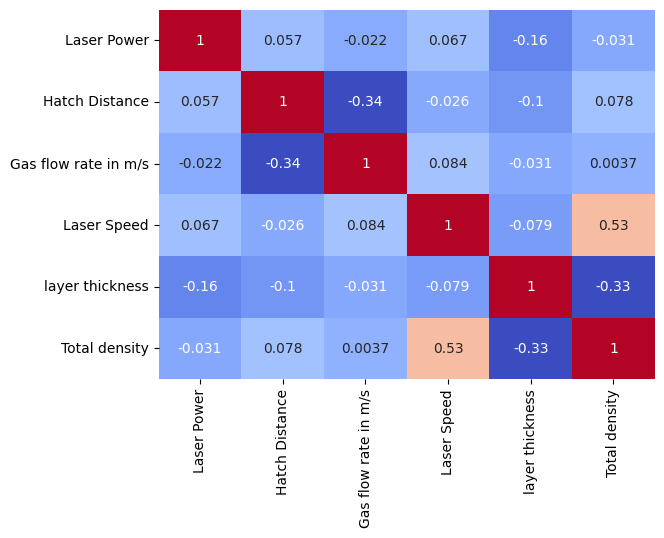

In [53]:
corr_matrix = df_drop.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, cbar=False)

Plot features against each other.

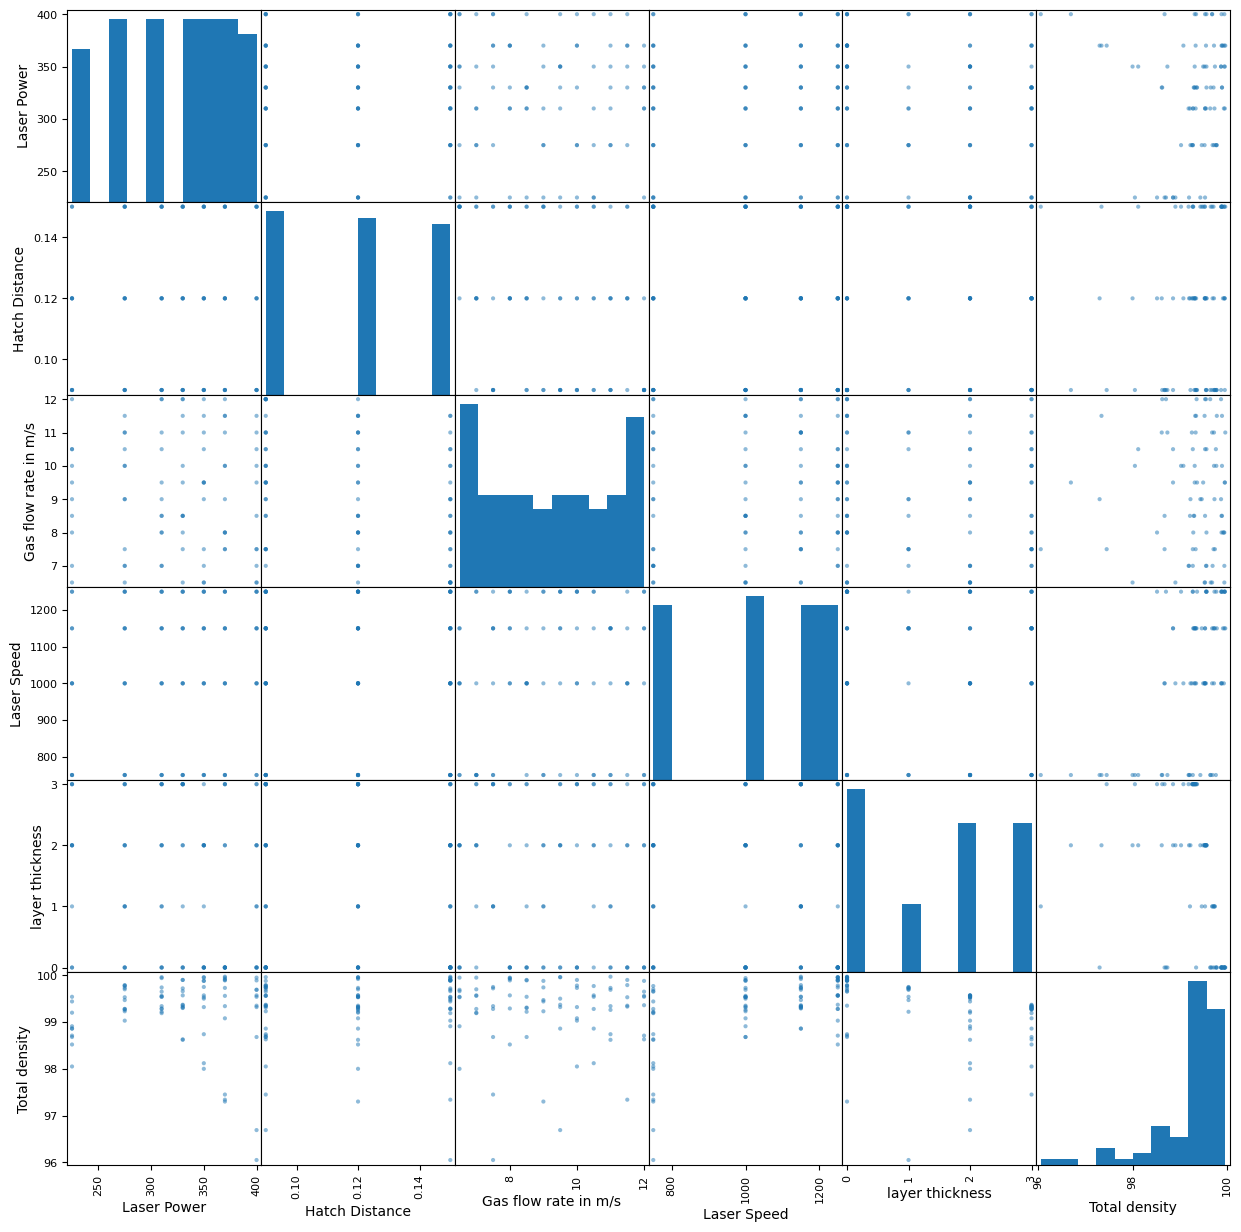

In [54]:
pd.plotting.scatter_matrix(df_drop, figsize=(15, 15));

Plot features against target variable.

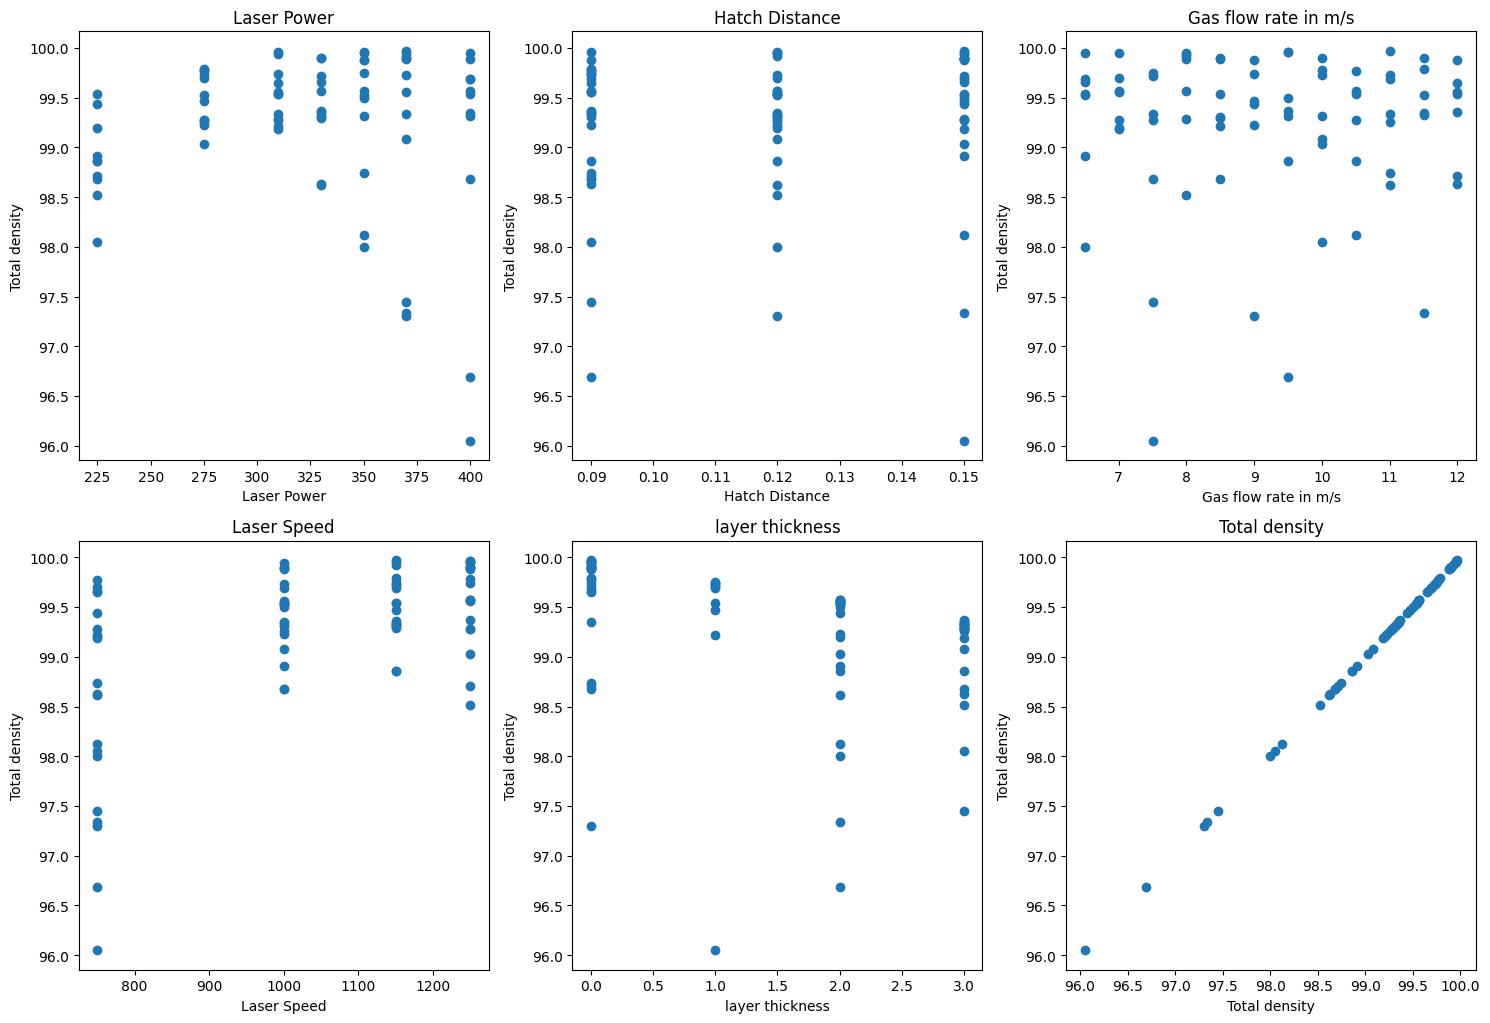

In [55]:
# plot total density versus other features

plt.figure(figsize=(15, 15))
for i, col in enumerate(df_drop.columns):
    plt.subplot(3, 3, i+1)
    plt.scatter(df[col], df['Total density'])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Total density')
    plt.tight_layout()

Investigate target variable. Target variable is right skewed.

In [56]:
y_train.nunique()

55

In [57]:
y_train.describe()

count    72.000000
mean     99.238472
std       0.779448
min      96.050000
25%      99.067500
50%      99.405000
75%      99.742500
max      99.970000
Name: Total density, dtype: float64

### Conclusions of EDA

The features below seem to have a somewhat linear relationship with the target variable.
- Layer thickness
- Laser speed
- Laser power

However, other parameters (hatch distance and gas flow rate) also might have complex and coupled relationships with the target. Thus, we will try using different feature combinations and compare the results.

## Data Preparation
---


Data is already in good form, there are no missing values to impute.

### Scaling

- MinMax scaling will be applied to the features as they are not distributed Gaussian.
- Note that in Gradient Boosted Trees, scaling didn't have any effect.

### Drop Irrelevant Features

Parameter, X_coord, Y_coord are irrelevant.

In [58]:
# drop parameter, x_coord and y_coord columns
X_train = X_train.drop(['Parameter', 'X_coord', 'Y_coord'], axis=1)
X_test = X_test.drop(['Parameter', 'X_coord', 'Y_coord'], axis=1)

## Model
---

Strategy:
1. Dummy model
2. Base model: linear regression
3. Improve the model: multilayer perceptron, gradient boosted trees

In [59]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Dummy regressor.

In [60]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

r2_score_dummy = dummy.score(X_val, y_val)
mse_dummy = mean_squared_error(y_val, dummy.predict(X_val))

print(f'R2 score: {r2_score_dummy:.2f}')
print(f'MSE: {mse_dummy:.2f}')

R2 score: -0.07
MSE: 0.74


Ridge regression. Linear regression with L2 regularisation improved the dummy model but did not perform well overall.

In [61]:
# LINEAR REGRESSION

# Apply minmax scaling to all features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# train linear regression
lr_model_scaled = Ridge(alpha=1.0)
lr_model_scaled.fit(X_train_scaled, y_train)

# train scores
r2_score_lr_train = lr_model_scaled.score(X_train_scaled, y_train)
mse_lr_train = mean_squared_error(y_train, lr_model_scaled.predict(X_train_scaled))

# validation scores
r2_score_lr = lr_model_scaled.score(X_val_scaled, y_val)
mse_lr = mean_squared_error(y_val, lr_model_scaled.predict(X_val_scaled))

print(f'R2 score (train): {r2_score_lr_train:.2f}')
print(f'R2 score (validation): {r2_score_lr:.2f}')
print(f'MSE (train): {mse_lr:.2f}')
print(f'MSE (validation): {mse_lr_train:.2f}')

R2 score (train): 0.30
R2 score (validation): 0.47
MSE (train): 0.37
MSE (validation): 0.39


MLP (simple feedforward neural network) regressor performed really bad.

In [62]:
# MLP REGRESSOR (NEURAL NETWORK)

mlp_model = MLPRegressor(hidden_layer_sizes=(4, 4), max_iter=10000, random_state=42)

# train the model
mlp_model.fit(X_train, y_train)

r2_score_mlp = mlp_model.score(X_val, y_val)
mse_mlp = mean_squared_error(y_val, mlp_model.predict(X_val))
print(f'R2 score: {r2_score_mlp:.2f}')
print(f'MSE: {mse_mlp:.2f}')

R2 score: -9.89
MSE: 7.54


Gradient boosting regressor. GBR performed the best but there is overfitting. Training R2 score is 1 whereas validation is 0.78.

In [63]:
# GRADIENT BOOSTING REGRESSOR

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# train scores
r2_score_gbr_train = gbr.score(X_train, y_train)
mse_gbr_train = mean_squared_error(y_train, gbr.predict(X_train))

# validation scores
r2_score_gbr = gbr.score(X_val, y_val)
mse_gbr = mean_squared_error(y_val, gbr.predict(X_val))

print(f'R2 score (train): {r2_score_gbr_train:.2f}')
print(f'R2 score (validation): {r2_score_gbr:.2f}')
print(f'MSE (train): {mse_gbr:.2f}')
print(f'MSE (validation): {mse_gbr_train:.2f}')

R2 score (train): 1.00
R2 score (validation): 0.78
MSE (train): 0.15
MSE (validation): 0.00


Comparison of models.

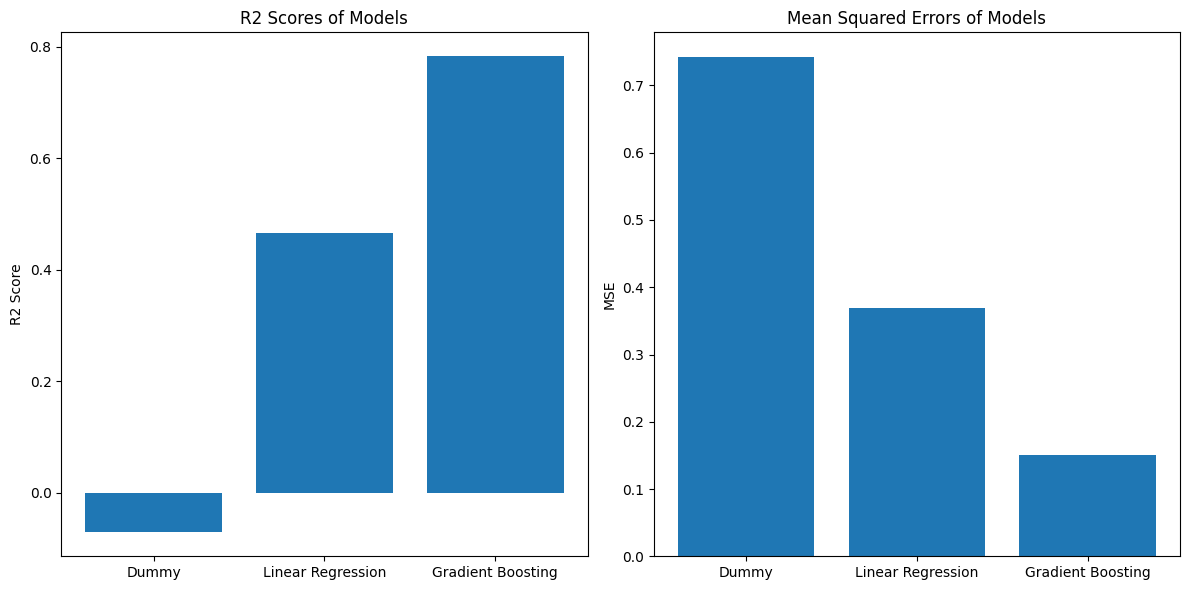

In [64]:
# Plot the R2 scores and MSEs of the models

r2_scores = [r2_score_dummy, r2_score_lr, r2_score_gbr]
mses = [mse_dummy, mse_lr, mse_gbr]

models = ['Dummy', 'Linear Regression', 'Gradient Boosting']
x = range(len(models))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, r2_scores, tick_label=models)
plt.title('R2 Scores of Models')
plt.ylabel('R2 Score')

plt.subplot(1, 2, 2)
plt.bar(x, mses, tick_label=models)
plt.title('Mean Squared Errors of Models')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

## Regularisation

We select our best model as Gradient Boosted Trees by looking at the previous results. Now, we will try to decrease over-fitting by applying regularisation.

### Learning Rate

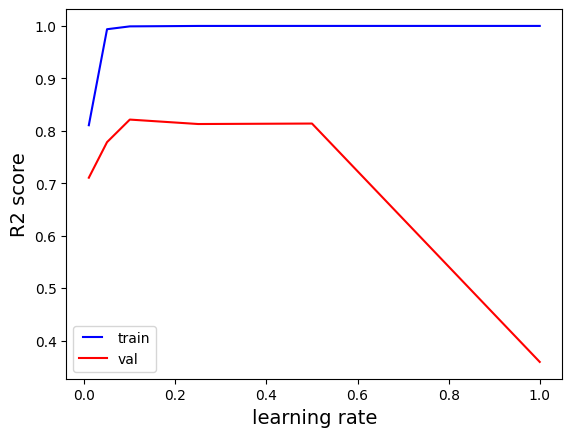

In [65]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingRegressor(learning_rate=eta, random_state=50)
   model.fit(X_train, y_train)
   
   train_pred = model.predict(X_train)
   r2_score = model.score(X_train, y_train)
   train_results.append(r2_score)

   y_pred = model.predict(X_val)
   r2_score = model.score(X_val, y_val)
   test_results.append(r2_score)


line1, = plt.plot(learning_rates, train_results, 'b', label='train')
line2, = plt.plot(learning_rates, test_results, 'r', label='val')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('R2 score', fontsize=14)
plt.xlabel('learning rate', fontsize=14)
plt.show()

Overfitting increases with higher learning rates. Thus, we will use the learning rate of 0.1.

### Number of Estimators

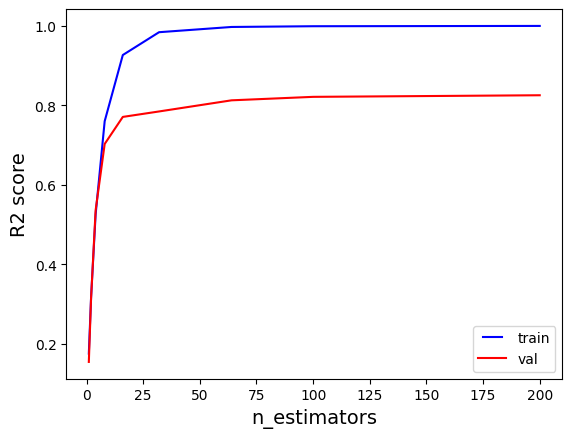

In [66]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    model = GradientBoostingRegressor(n_estimators=estimator, random_state=50)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    r2_score = model.score(X_train, y_train)
    train_results.append(r2_score)

    y_pred = model.predict(X_val)
    r2_score = model.score(X_val, y_val)
    test_results.append(r2_score)


line1, = plt.plot(n_estimators, train_results, 'b', label='train')
line2, = plt.plot(n_estimators, test_results, 'r', label='val')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('R2 score', fontsize=14)
plt.xlabel('n_estimators', fontsize=14)
plt.show()

Increasing the estimator number does not improve the results after some point. However, low values are performing poorly for both training and validation datasets. Thus, we will select 100 for n_estimators.

### Maximum Depth

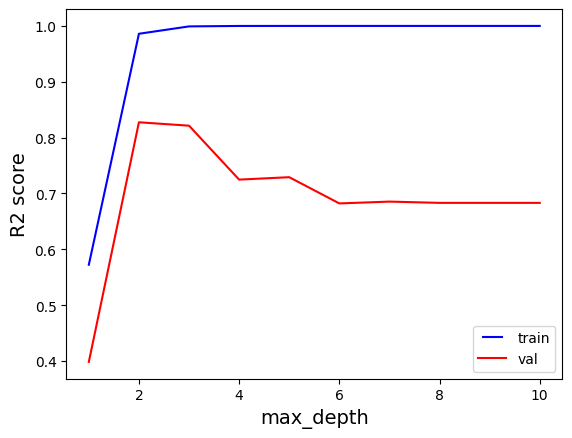

In [67]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingRegressor(max_depth=max_depth, random_state=50)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    r2_score = model.score(X_train, y_train)
    train_results.append(r2_score)

    y_pred = model.predict(X_val)
    r2_score = model.score(X_val, y_val)
    test_results.append(r2_score)


line1, = plt.plot(max_depths, train_results, 'b', label='train')
line2, = plt.plot(max_depths, test_results, 'r', label='val')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('R2 score', fontsize=14)
plt.xlabel('max_depth', fontsize=14)
plt.show()

This may be the most critical parameter for overfitting; overfitting increases significantly with high depth. As we have only five features, it makes sense to use a low max_depth. The plot also suggests that the optimal value is 2. Thus, we will use 2 for max_depth.

### Final, Regularised Version

In [68]:
# GBR: Regularisation applied

gbr = GradientBoostingRegressor(
    learning_rate=0.1, 
    max_depth=2,
    n_estimators=100, 
    random_state=None)

gbr.fit(X_train, y_train)

# train scores
r2_score_gbr_train = gbr.score(X_train, y_train)
mse_gbr_train = mean_squared_error(y_train, gbr.predict(X_train))

# validation scores
r2_score_gbr = gbr.score(X_val, y_val)
mse_gbr = mean_squared_error(y_val, gbr.predict(X_val))

print(f'R2 score (train): {r2_score_gbr_train:.2f}')
print(f'R2 score (validation): {r2_score_gbr:.2f}')
print(f'MSE (train): {mse_gbr:.2f}')
print(f'MSE (validation): {mse_gbr_train:.2f}')

R2 score (train): 0.99
R2 score (validation): 0.83
MSE (train): 0.12
MSE (validation): 0.01


## Test Final Model on Unseen Data

In [69]:
# Use all of tha data for training (add validation data to training data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr.fit(X_train, y_train)
r2_score = gbr.score(X_test, y_test)
print(f'R2 score: {r2_score:.2f}')

R2 score: 0.77


## Evaluate Predictions

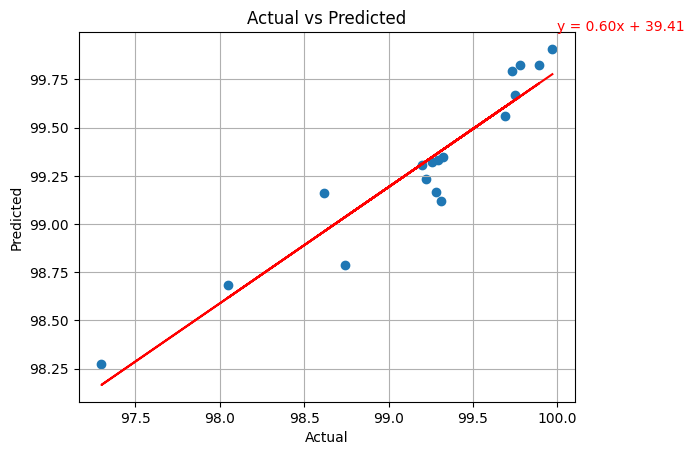

In [70]:
y_pred = gbr.predict(X_test)

# find least squares line between actual and predicted values
m, b = np.polyfit(y_test, y_pred, 1)
plt.scatter(y_test, y_pred)
plt.plot(y_test, m*y_test + b, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.text(100, 100, f'y = {m:.2f}x + {b:.2f}', color='red')
plt.grid()
plt.show()

Find the probability of prediction being within a certain range of the actual value.

Probability of predicted density being within range [true density + - 0.2]: 82.35%


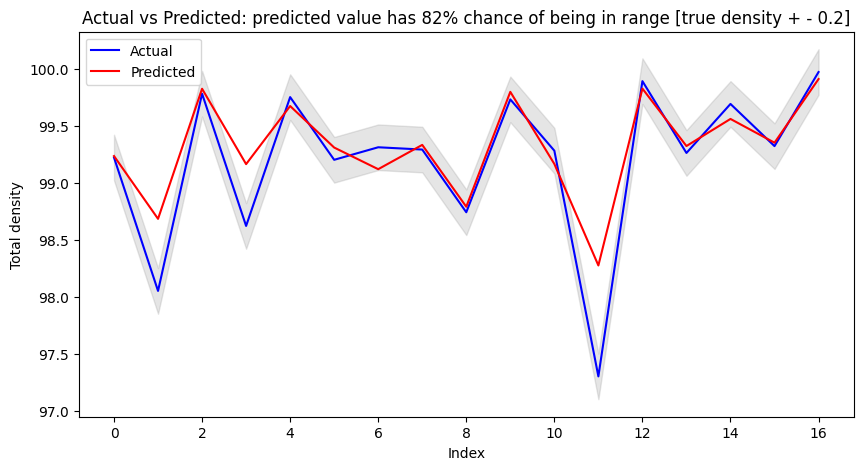

In [71]:
y_pred = pd.Series(y_pred)
y_test = y_test.reset_index(drop=True)

# Define the range (adjust delta based on your requirements)
delta = 0.2
y_actual_range = y_test - delta, y_test + delta

# Check if the predicted value falls within the range
predictions_within_range = y_pred.between(y_actual_range[0], y_actual_range[1])

# Calculate the probability of prediction within the range
probability_within_range = sum(predictions_within_range) / len(predictions_within_range)

# print as a percentage
print(f"Probability of predicted density being within range [true density + - 0.2]: {probability_within_range*100:.2f}%")

# plot confidence interval
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.fill_between(y_test.index, y_actual_range[0], y_actual_range[1], color='gray', alpha=0.2)
plt.title(f'Actual vs Predicted: predicted value has {probability_within_range*100:.0f}% chance of being in range [true density + - 0.2]')
plt.xlabel('Index')
plt.ylabel('Total density')
plt.legend()
plt.show()


In the above plot, only three times the predicted value was not in the specified interval (true_density + - 0.2).